## Machine Learning Model Building Harness for Image Classification

### Functions:

prep_pixels           - Simply normalizes the training and testing data.  
summarize_diagnostics - Plots cross entropy loss and (validation) accuracy.  
run_test_harness      - Main harness used to run the full model from start to finish. You specify all the parameters here.  
load_server_dataset   - Loads the data given a `folder_name`, which is either ny_dataset, fremont_dataset, or sa_dataset.  
define_model          - Creates a model that has the `.fit` and `.evaluate` methods.

To create your own model, simply alter the `define_model` function, and make sure that the model you created has those two methods.  
Also, make sure that your preprocessing in `load_server_dataset` is appropriate for the data you are using.

---

Model architecture (as of 11/3/20):   
- input_shape: (100, 100, 3)
- using VGG16 pre-trained layers up until the flattened layers
- there, we added 2 layers of 512 hidden nodes, and then a softmax output layer
- in the future, can consider preprocessing the data by standardizing the features or rotating images for more robust performance
- can also consider adding dropout layers, which we can hopefully test with more varied data (model already hit 100% test accuracy)

Hyperparameter tuning results:  
lr = 0.05  
batch_size = 60

Other hyperparameters (not hyperparameter tuned since we already hit 100% test accuracy on the data in the server):  
L2 regularization = None

In [10]:
# preprocessing
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import cv2

from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean #scaling options
import skimage
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, mean_squared_error
from sklearn.model_selection import KFold

# modeling 
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input, Dropout, BatchNormalization
from keras.utils import to_categorical
# from keras.optimizers import SGD
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

def prep_pixels(train, test):
    train_norm = train.astype('float32') / 255.0
    test_norm = test.astype('float32') / 255.0
    return train_norm, test_norm
 
# plot diagnostic learning curves
def summarize_diagnostics(history, model, testX, testY, classes):

    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()

    # save plot to file
    plt.savefig('diagnostics/vgg16_diagnostic_plot_vl.png')
    plt.close()

    # plot confusion matrix, print precision/recall
    # disp = plot_confusion_matrix(history, testX, testY,
    #                              display_labels=classes,
    #                              cmap=plt.cm.Blues,
    #                              normalize='true')
    # disp.ax_.set_title('Normalized Confusion Matrix')

    # plot confusion matrix, print precision/recall
    # p = model.predict(testX)
    # print('---------PREDICTIONS---------')
    # print(p)
    # cm = confusion_matrix(y_true=testY, y_pred=p)
    # plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.title(title)
    # plt.colorbar()
    # tick_marks = np.arange(len(classes))
    # plt.xticks(tick_marks, classes, rotation=45)
    # plt.yticks(tick_marks, classes)

    # cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # print("Normalized confusion matrix")
    # print(cm)

    # thresh = cm.max() / 2.
    # for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    #     plt.text(j, i, cm[i, j],
    #         horizontalalignment="center",
    #         color="white" if cm[i, j] > thresh else "black")

    # plt.ylabel('True label')
    # plt.xlabel('Predicted label')
    # plt.tight_layout()
    
# run the test harness for evaluating a model
def run_test_harness(folder_name, epochs=100, batch_size=64, verbose=2, test_size=0.1, random_state=100, n=-1, shape = (100, 100, 3), diagnostics = True, lr=0.05):
    # load dataset

    if folder_name == 'all':
        trainX, trainY, testX, testY, shape, classes = load_all_server_dataset(test_size=test_size,                                                                         random_state=random_state, n=n, shape = shape)
    elif folder_name == 'binary':
        trainX, trainY, testX, testY, shape, classes = load_binary_dataset(test_size=test_size,                                                                         random_state=random_state, n=n, shape = shape)
    else:
        trainX, trainY, testX, testY, shape, classes = load_server_dataset(folder_name, test_size=test_size,                                                                random_state=random_state, n=n, shape = shape)
    print('Dataset Loaded!')

    # prepare pixel data
    # trainX, testX = prep_pixels(trainX, testX)
    # print('Dataset Preprocessed!')
    print('Dataset Preprocessing Turned Off!')

    # define model
    print('Defining Model...')
    model = define_model(classes, shape, lr=lr)

    # fit model
    print('Fitting Model...')
    # Read this on stack overflow:
    # @source: https://keras.io/api/callbacks/reduce_lr_on_plateau/
    # reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
    #                           patience=5, min_lr=0.001)
    # model.fit(X_train, Y_train, callbacks=[reduce_lr])
    # reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5,                                                                   min_lr=0.001)
    # history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, validation_data=(testX, testY), verbose=verbose, callbacks = [reduce_lr])
    history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, validation_data=(testX, testY), verbose=verbose)
    print('Model fitted! Epochs=%d, Batch Size=%d' % (epochs, batch_size))
    
    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=verbose)
    print('Model Evalution:')
    print('> %.3f' % (acc * 100.0))
    # learning curves
    if diagnostics:
        summarize_diagnostics(history, model, testX, testY, classes)

    print('----FINISHED----')
    
    return model

In [9]:
# loading in data for kfold cv
trainX, trainY, testX, testY, shape, classes = load_all_server_dataset()


Classes:  ['unknown' 'kitchen' 'bathroom' 'bedroom' 'house_view' 'living_room'
 'road_view' 'yard' 'porch' 'dining_room' 'porch_yard' 'garage']
Number of observations: 1336


In [42]:
# testing the kfold stuff on the data
n_splits = 5
# lr = [0.001, 0.01, 0.1, 1] # 0.01 best: MSE = [0.02341774, 0.00772396, 0.00837915, 0.02089699]
# lr = [0.005, 0.01, 0.05] # 0.05 best: MSE = [0.02314396, 0.02623941, 0.01162545]
# batch_size = [32, 64, 100] # 64 best: MSE = [0.02740691, 0.00986043, 0.09347975]
batch_size = [50, 60, 70]

# perform k-fold cv
mses = np.full((n_splits,len(lr)),np.nan)
accs = np.full((n_splits,len(lr)), np.nan)
kf = KFold(n_splits = n_splits, random_state = 2020, shuffle = True)
fold = 0
for train_i, val_i in kf.split(trainX):
    # get training and validation values
    trainX_fold = trainX[train_i]
    valX_fold = trainX[val_i]
    trainY_fold = trainY[train_i]
    valY_fold = trainY[val_i]
    
    print('Fold ' + str(fold) + ' of ' + str(n_splits) + '...')
    for i in range(len(batch_size)): # loop through hyperparameter values

        # define model
        print('Defining Model...')
        model = define_model(classes, shape, lr=0.05, verbose=0)

        # fit model
        print('Fitting Model...')
        history = model.fit(trainX_fold, trainY_fold, epochs=10, batch_size=batch_size[i], validation_data=(valX_fold, valY_fold), verbose=0)
        print('Model fitted! Epochs=%d, Batch Size=%d' % (10, batch_size[i]))
        
        # get predictions
        y_pred = model.predict(valX_fold) 
        
        # save MSE for this fold and hyperparameter value
        mses[fold, i] = mean_squared_error(y_pred, valY_fold)

        _, acc = model.evaluate(testX, testY, verbose=0)
        accs[fold, i] = acc 

    fold += 1

average_mses = np.mean(mses, axis=0)
average_accs = np.mean(accs, axis=0)
average_mses, average_accs


Defining Model...
Fitting Model...
Model fitted! Epochs=10, Batch Size=50
Defining Model...
Fitting Model...
Model fitted! Epochs=10, Batch Size=60
Defining Model...
Fitting Model...
Model fitted! Epochs=10, Batch Size=70
Defining Model...
Fitting Model...
Model fitted! Epochs=10, Batch Size=50
Defining Model...
Fitting Model...
Model fitted! Epochs=10, Batch Size=60
Defining Model...
Fitting Model...
Model fitted! Epochs=10, Batch Size=70
Defining Model...
Fitting Model...
Model fitted! Epochs=10, Batch Size=50
Defining Model...
Fitting Model...
Model fitted! Epochs=10, Batch Size=60
Defining Model...
Fitting Model...
Model fitted! Epochs=10, Batch Size=70
Defining Model...
Fitting Model...
Model fitted! Epochs=10, Batch Size=50
Defining Model...
Fitting Model...
Model fitted! Epochs=10, Batch Size=60
Defining Model...
Fitting Model...
Model fitted! Epochs=10, Batch Size=70
Defining Model...
Fitting Model...
Model fitted! Epochs=10, Batch Size=50
Defining Model...
Fitting Model...
Mod

(array([0.04767436, 0.00631983, 0.07143497]),
 array([0.83469387, 0.96938777, 0.71224489]))

In [3]:
def load_server_dataset(folder_name, test_size=0.1, random_state=100, n=-1, shape = (100, 100, 3)):
    '''
    Given a folder name on Materiall's shared server:
    (1) read in all the files, 
    (2) convert them to pixels, 
    (3) separate them into train and testing data 
        (default test_size and random_state for reproducibility)
        TO_DO: need a better way to split so num_classes is the same in test/train

    Return: X_train, X_test, y_train, y_test, shape of each image
    '''

    # read in filelist and rename columns
    df = pd.read_csv(f'{folder_name}/filelist', sep=" ", header=None)
    df.columns = ['link', 'filepath', 'class', 'probability']

    # filter
    classes = ['living_room', 'house_view', 'kitchen', 'yard', 'garage']
    df = df[df['probability'] > 0.95]
    df = df[df['class'].isin(classes)]

    # change dataset size if specified
    if n > 0:
        df = df.sample(n)

    print("Number of observations: " + str(df.shape[0]))

    # add pixels column, resize images (not proportional)
    df['pixels'] = df['link'].apply(lambda x: resize(io.imread(x), shape)) #might take a while

    #split and return training and test sets
    X = np.array([x for x in df['pixels']])
    y = df['class']
    X_train, X_test, y_train, y_test = train_test_split(X, y, \
                                                        test_size=test_size, \
                                                        random_state=random_state)

    # integer encode target labels so that keras can one hot
    label_encoder = LabelEncoder()
    vec_train = label_encoder.fit_transform(y_train)
    vec_test = label_encoder.fit_transform(y_test)

    # one hot encode target values
    y_train = to_categorical(vec_train)
    y_test = to_categorical(vec_test)

    #trainX, trainY, testX, testY 
    #(make sure ordering is correct to match harness function)
    return X_train, y_train, X_test, y_test, shape, classes

In [4]:
def load_all_server_dataset(test_size=0.1, random_state=100, n=-1, shape = (100, 100, 3)):
    '''
    Loads in data from all three datasets instead of for a specific folder.
    '''
    all_df = pd.DataFrame()
    folders = ['ny_dataset', 'fremont_dataset', 'sa_dataset']

    for folder_name in folders: 
        df = pd.read_csv(f'{folder_name}/filelist', sep=" ", header=None)
        df.columns = ['link', 'filepath', 'class', 'probability']

        # filter
        # classes = ['living_room', 'house_view', 'kitchen', 'yard', 'garage']
        df = df[df['probability'] > 0.90]
        # df = df[df['class'].isin(classes)]

        all_df = all_df.append(df)

    # change the label of all the classes with less than 20 images into `unknown`
    all_classes = all_df['class'].value_counts()
    all_df.loc[all_df['class'].apply(lambda x: x in all_classes.index[all_classes < 20]).values, 'class'] = 'unknown'
    classes = all_df['class'].unique()

    print('Classes: ', classes)

    # change dataset size if specified
    if n > 0:
        all_df = all_df.sample(n)

    print("Number of observations: " + str(all_df.shape[0]))

    # add pixels column, resize images (not proportional)
    all_df['pixels'] = all_df['link'].apply(lambda x: resize(io.imread(x), shape)) #might take a while

    #split and return training and test sets
    X = np.array([x for x in all_df['pixels']])
    y = all_df['class']
    X_train, X_test, y_train, y_test = train_test_split(X, y, \
                                                        test_size=test_size, \
                                                        random_state=random_state)

    # integer encode target labels so that keras can one hot
    label_encoder = LabelEncoder()
    vec_train = label_encoder.fit_transform(y_train)
    vec_test = label_encoder.fit_transform(y_test)

    # one hot encode target values
    y_train = to_categorical(vec_train)
    y_test = to_categorical(vec_test)

    #trainX, trainY, testX, testY 
    #(make sure ordering is correct to match harness function)
    return X_train, y_train, X_test, y_test, shape, classes


In [5]:
def load_binary_dataset(test_size=0.1, random_state=100, n=-1, shape = (100, 100, 3)):

    df = pd.read_csv('combined_binary_dataset.csv')
    df = df[df['probability'] > 0.90]
    classes = ['inside', 'outside']

    # change dataset size if specified
    if n > 0:
        df = df.sample(n)

    print("Number of observations: " + str(df.shape[0]))

    # add pixels column, resize images (not proportional)
    df['pixels'] = df['link'].apply(lambda x: resize(io.imread(x), shape)) #might take a while

    #split and return training and test sets
    X = np.array([x for x in df['pixels']])
    y = df['class']
    X_train, X_test, y_train, y_test = train_test_split(X, y, \
                                                        test_size=test_size, \
                                                        random_state=random_state)

    # integer encode target labels so that keras can one hot
    label_encoder = LabelEncoder()
    vec_train = label_encoder.fit_transform(y_train)
    vec_test = label_encoder.fit_transform(y_test)

    # one hot encode target values
    y_train = to_categorical(vec_train)
    y_test = to_categorical(vec_test)

    #trainX, trainY, testX, testY 
    #(make sure ordering is correct to match harness function)
    return X_train, y_train, X_test, y_test, shape, classes


In [6]:
# define cnn model
def define_model(classes, shape=(32,32,3), lr=0.01, momentum = 0.9, verbose=1):

    # grab the pre-trained VGG16 model, removing the top layers and changing the input shape
    vgg_model = VGG16(weights="imagenet", include_top=False, input_shape=shape)
        
    # freeze pre-trained layers
    for layer in vgg_model.layers:
        layer.trainable = False

####### VINCENT'S PREVIOUS CODE #####################
    # add new classifier layers
    flat1 = Flatten()(vgg_model.layers[-1].output)
    class1 = Dense(512, activation='relu')(flat1)
    # drop1 = Dropout(0.7)(class1)
    class2 = Dense(512, activation='relu')(class1)
    output = Dense(len(classes), activation='softmax')(class2)

####################################################

# Parker's mode: adapted From stackoverflow post
# https://stackoverflow.com/questions/56632808/why-is-my-validation-accuracy-stuck-around-65-and-how-do-i-increase-it
    # final_layers = Sequential()
    # final_layers.add(Flatten(input_shape=vgg_model.output_shape[1:]))
    # final_layers.add(Dropout(0.5))
    # final_layers.add(Dense(512, activation='relu'))
    # final_layers.add(BatchNormalization())
    # final_layers.add(Dropout(0.5))
    # final_layers.add(Dense(5, activation='softmax'))

# End adapted section

    # define new model with top layers
    model = Model(inputs=vgg_model.inputs, outputs=output)
    # opt = tf.keras.optimizers.RMSprop(learning_rate=0.1)
    opt = SGD(lr=0.01, momentum= 0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # for output while training
    if verbose > 0:
        model.summary()

    return model

In [9]:
# optional params: epochs=100, batch_size=64, verbose=2, test_size=0.1, random_state=100, n=-1, shape = (100, 100, 3)
run_test_harness('all', epochs=25, test_size = 0.1, shape=(100, 100, 3), batch_size=60, lr = 0.05)

Classes:  ['unknown' 'kitchen' 'bathroom' 'bedroom' 'house_view' 'living_room'
 'road_view' 'yard' 'porch' 'dining_room' 'porch_yard' 'garage']
Number of observations: 1336
Dataset Loaded!
Dataset Preprocessing Turned Off!
Defining Model...
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
___________

Number of observations: 1122
Dataset Loaded!
Dataset Preprocessing Turned Off!
Defining Model...
Model: "functional_137"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_69 (InputLayer)        [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_____________________

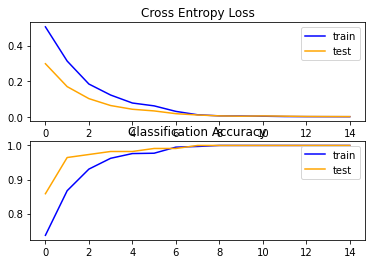

In [52]:
run_test_harness('binary', epochs=15, shape=(100, 100, 3), batch_size=60, lr = 0.05)

In [ ]:
io.imshow('diagnostics/vgg16_diagnostic_plot_vl.png')